# Part I

We look at convergence diagnostics for analyzing whether the Stan MCMC sampler is working well or not. Your pre-class task is to analyze the diagnostic output provided for the mixture of normals problem we have been using for the past few weeks. In class, we review the same diagnostic output for some other Bayesian models.

## The Gaussian mixture problem

We use Stan to draw samples from the posterior distribution of the Gaussion mixture with unknown mean and standard deviation.

$$p(\mu, \sigma\,|\,\{x\}) \propto \text{Normal}(\mu\,|\,0, 5^2)\,\text{Gamma}(\sigma\,|\,2, 1) \prod_{i=1}^{20} \left[0.7\,\text{Normal}(x_i\,|\,0,4^2) + 0.3\,\text{Normal}(x_i\,|\,\mu,\sigma^2)\right]$$

The call to the `stan_model.sampling()` function below runs a particular Hamiltonian Monte Carlo sampler, called the No-U-Turn Sampler, with 4 Markov chains, a 1000 step warm-up phase and a 1000 step sampling phase for each chain. As a result we get 4000 samples for each unobserved variable.

## Task 1
After running the code below, comment on the Stan output.
 1. Use the Rhat value to comment on whether the Markov chains converged properly or not. Explain your answer.
 2. What are the total number of samples and the effective number of samples? Are these values good or not?

In [1]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas
import seaborn

%matplotlib inline

In [2]:
# The Stan model and data. Running this cell compiles the Stan model, which
# takes some time.

stan_data = {
  'N': 20,
  'x': [
    -4.12794, -2.15233,  3.04630, -10.77442, -6.98516,  5.53611,  1.29475,
     7.63900, -5.65012, -4.47807,  -0.45514, -3.96941, -0.42255, -2.46209,
     1.88668,  3.09557,  4.31000,   3.30503,  0.85483,  4.36821]}

stan_code = """
data {
  int<lower=0> N;  // Number of data
  real x[N];       // Data values
}

parameters {
  real mu;              // Mean and standard deviation
  real<lower=0> sigma;  // of unknown Gaussian
}

model {
  // Priors
  mu ~ normal(0, 5);
  sigma ~ gamma(2, 1);

  // Likelihood
  for(i in 1:N) {
    target += log_sum_exp(
      log(0.7) + normal_lpdf(x[i] | 0, 4),
      log(0.3) + normal_lpdf(x[i] | mu, sigma));
  }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_59b238345b62dba164adf99b3c313c33 NOW.


In [3]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

parameters = ['mu', 'sigma']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

Inference for Stan model: anon_model_59b238345b62dba164adf99b3c313c33.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     -0.23    0.12   3.72  -7.25  -3.45    0.2   2.96   5.59   1044    1.0
sigma    2.9    0.04   1.49   0.69   1.76   2.67   3.82   6.26   1522    1.0

Samples were drawn using NUTS at Tue Dec 17 12:01:19 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Now, comment on the Stan output above.

1. *Use the Rhat value to comment on whether the Markov chains converged properly or not. Explain your answer.*

The Rhat value for mu and sigma are both equal to 1, this suggests that the samples are well mixed and the Markov chains have converged.

 
2. *What are the total number of samples and the effective number of samples? Are these values good or not?*

The total number of samples is 4000 excludind the warmup phase. The n_eff is the number of effective samples and it exceeds 1000 for both mu and sigma, hence, it's good enough to work with few hundred independent samples.

## Task 2
Run the code below and use the plots to answer the following questions.

1. *Are the samples correlated or reasonably independent?*

According to the autocorrelation plot, mu and sigma samples are not correlated but are reasonably independent

2. *What information does the pair plot provide?*

Shows one-dimension sampled distribution for parameters

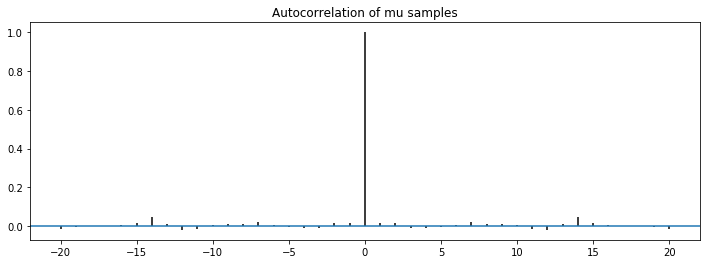

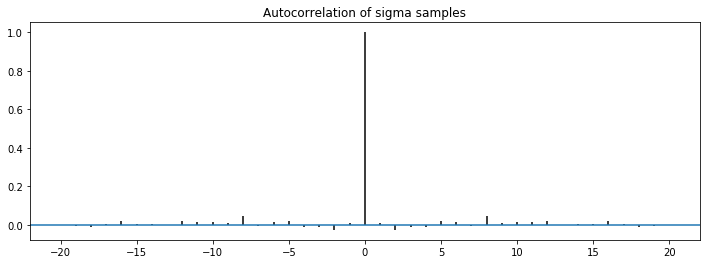

In [4]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal    
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


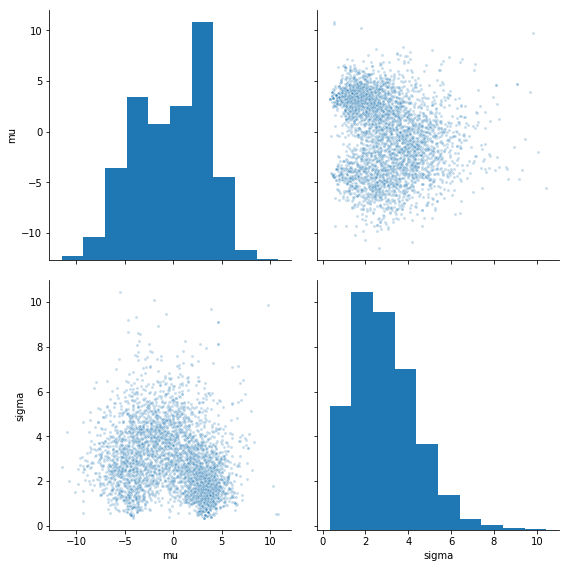

In [5]:
# Make pair plot of the posteriors over all parameters of the model.
df = pandas.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

## Task 3
Since the posterior distribution is 2-dimensional we can visualize it. This will not be the case with higher-dimensional distributions.

Run the code below and answer the following question.

- *Are the Stan samples distributed according to the target distribution?*

The density of the samples location seems to mirror the probability mass of the traget distribution, we can then be confident that the Stan samples are distributed according to the target distribution.

In [6]:
# Plot of the 4000 Stan samples on a 2-d level plot of the posterior pdf
def unnormalized_posterior(mu, sigma):
    if sigma <= 0:
        return np.float64(0)
    else:
        return (
            stats.gamma.pdf(sigma, a=2, scale=1) *
            stats.norm.pdf(mu, loc=0, scale=5) *
            np.prod(0.7 * stats.norm.pdf(stan_data['x'], loc=0, scale=4) +
                    0.3 * stats.norm.pdf(stan_data['x'], loc=mu, scale=sigma)))

plot_mu_range = [-15, 15]
plot_sigma_range = [0, 10]

# Plot of the unormalized posterior using a 2-d contour plot.
mu = np.linspace(plot_mu_range[0], plot_mu_range[1], 300)
sigma = np.linspace(plot_sigma_range[0], plot_sigma_range[1], 300)
posterior = np.empty((len(sigma), len(mu)))
for i in range(len(sigma)):
    for j in range(len(mu)):
        posterior[i,j] = unnormalized_posterior(mu[j], sigma[i])

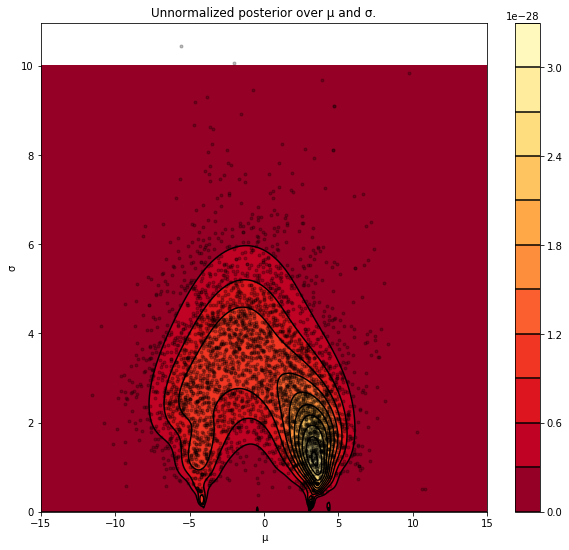

In [7]:
plt.figure(figsize=(10, 9))
filled = plt.contourf(mu, sigma, posterior, 11, cmap=plt.cm.YlOrRd_r)
lines = plt.contour(mu, sigma, posterior, 11, colors='black')
plt.plot(samples['mu'], samples['sigma'], 'k.', alpha=0.25)
plt.title('Unnormalized posterior over μ and σ.')
plt.xlabel('μ')
plt.ylabel('σ')
color_bar = plt.colorbar(filled)
color_bar.add_lines(lines)
plt.show()